In [8]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

### Setting working directory

In [3]:
import os
is_colab = 'google.colab' in str(get_ipython())
if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DT-ImageDataExtraction' if is_colab else '.'
os.chdir(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## LOADING THE DATA

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("./data/receipt_items.csv")

# Convert 'UNKNOWN' or similar placeholders to NaN
df.replace('UNKNOWN', pd.NA, inplace=True)

# Drop rows with NaN in 'quantity', 'unitprice', 'cost', or 'item_name'
df = df.dropna(subset=['item_name', 'quantity', 'unitprice', 'cost'])
df = df[~ df["category"].str.contains("alco", case=False, na=False)]
df["category"] = df["category"].apply(lambda x: "beverages" if "non" in x.lower() else x)

# Convert relevant columns to numeric types
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['unitprice'] = pd.to_numeric(df['unitprice'], errors='coerce')
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

# Drop rows with NaN again after conversion
df = df.dropna(subset=['quantity', 'unitprice', 'cost'])

# Select feature columns and target column
X = df[['item_name', 'quantity', 'unitprice', 'cost']]
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test)

(539, 135)

<Axes: xlabel='category'>

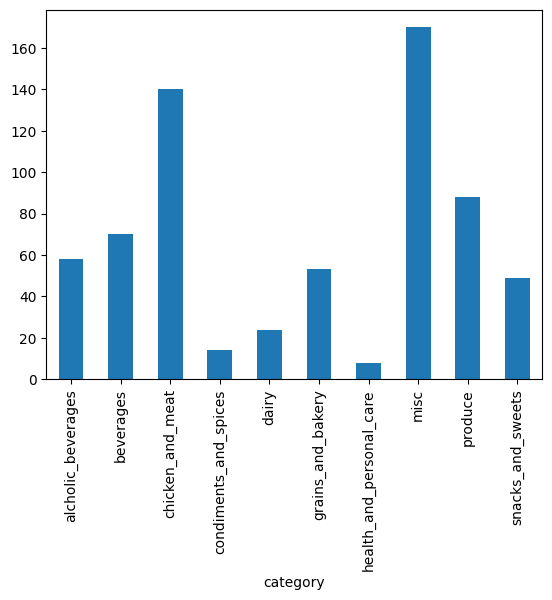

In [5]:
# group data by category
grouped_data = df.groupby('category')
# histogram
grouped_data['category'].count().plot(kind='bar')


In [6]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer




# Define preprocessing pipeline for item_name (NLP), numerical, and categorical data
vectorizer = TfidfVectorizer(stop_words='english')

# Preprocessing pipeline for numerical features
numerical_features = ["quantity", "unitprice", "cost"]
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical data preprocessing (no need to include 'category' as a feature in X)
categorical_features = []  # No categorical features except for 'category' as target
categorical_transformer = Pipeline(steps=[])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('item_name', vectorizer, 'item_name'),
        ('num', numerical_transformer, numerical_features)
    ])

# KNN Classifier Pipeline
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Fit KNN model
knn_model.fit(X_train, y_train)

# Predict with KNN (Example: Predict for the first item in X_test)






Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('item_name',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'item_name'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity', 'unitprice',
                                                   'cost'])])),
                ('classifier', KNeighborsClassifier())])

## Finding the optimal K

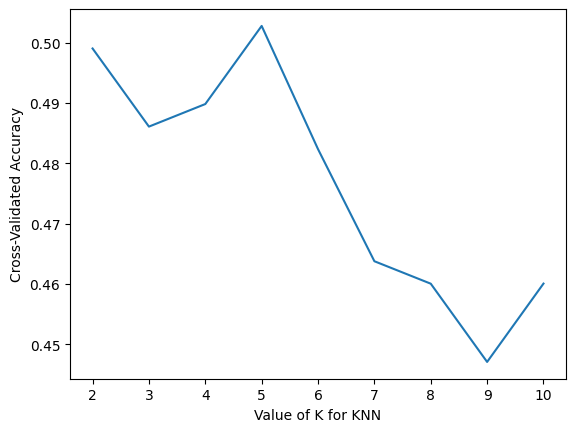

In [ ]:
from sklearn.model_selection import cross_val_score
k_range = range(2, 11)
cv_scores = []  # To store cross-validation scores

# Perform cross-validation for each k
for k in k_range:
    knn_model_ = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    # Fit KNN model
    #knn_model.fit(X_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model_, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.plot(k_range, cv_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

## CONFUSION MATRIX

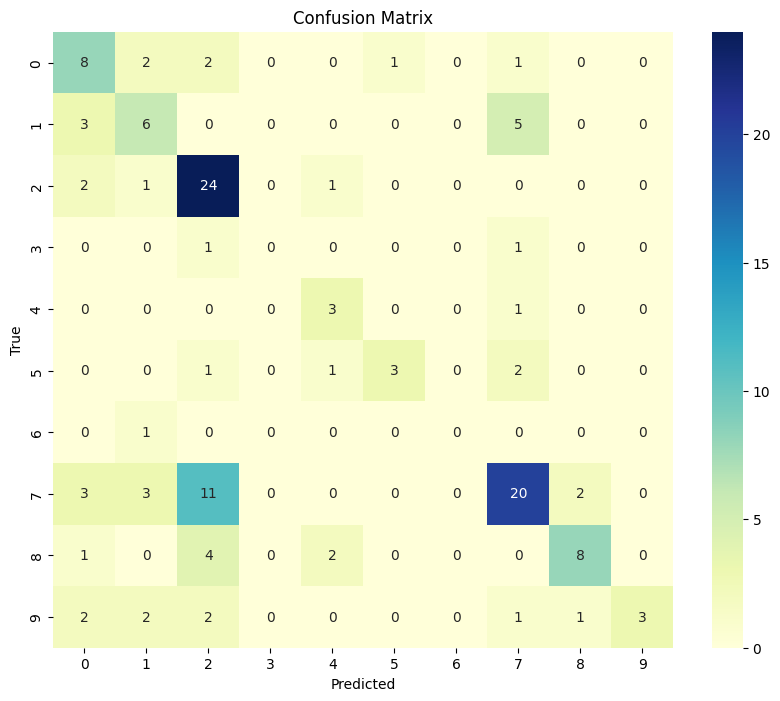

Accuracy on test set: 55.56%
Precision on test set: 59.60%
Recall on test set: 55.56%
F1 score on test set: 54.24%


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluate the model (accuracy)
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    # print('Predicted',y_pred)
    # print('Actual data',y_test)
    precision = precision_score(y, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y, y_pred, average='weighted',zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted',zero_division=0)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return accuracy, precision, recall, f1


accuracy, precision, recall, f1 = evaluate_model(knn_model, X_test, y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print(f"Precision on test set: {precision * 100:.2f}%")
print(f"Recall on test set: {recall * 100:.2f}%")
print(f"F1 score on test set: {f1 * 100:.2f}%")

In [ ]:
# Prediction function
def predict_category(model, item_features):
    """
    Predicts the category of an item using the trained model.

    Parameters:
    - model: The trained KNN model.
    - item_features: A DataFrame containing the item features for prediction.

    Returns:
    - Predicted category of the item.
    """
    # Ensure the input is in the right shape (2D array or DataFrame)
    prediction = model.predict(item_features)
    return prediction[0]

example = pd.DataFrame({
    "item_name": ["SPROUTED BROWN BREAD"],
    "quantity": [1],
    "unitprice": [2.99],
    "cost": 2.99
})

predict_category(knn_model, example)

'grains_and_bakery'

# Similar items with K-MEANS

### Determing the Number of Clusters

Text(0, 0.5, 'Distortion (Inertia)')

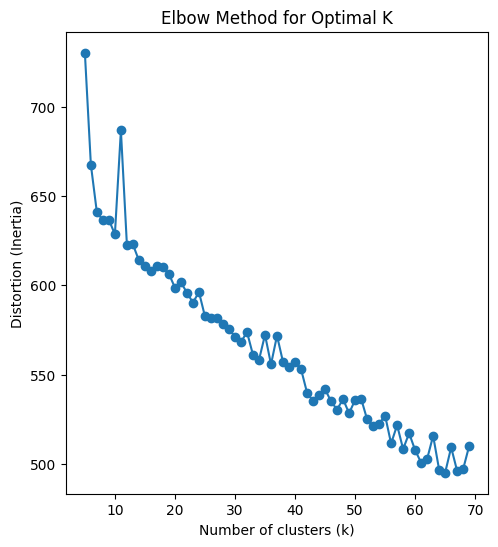

In [16]:
from sklearn.cluster import KMeans



k_range = range(5, 70)
distortions = []

for n_clusters in k_range:
  kmeans_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('clustering', KMeans(n_clusters=n_clusters))
  ])

  # Fit K-Means model
  kmeans_model.fit(X)
  kmeans_step = kmeans_model.named_steps['clustering']
  distortions.append(kmeans_step.inertia_)


# Plot the elbow curve
plt.figure(figsize=(12, 6))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(k_range, distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')



In [20]:
from sklearn.cluster import KMeans

n_clusters =  40
# K-Means Clustering Pipeline
kmeans_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=n_clusters))
])

# Fit K-Means model
kmeans_model.fit(X)

# Assign clusters to the items
df['cluster'] = kmeans_model.predict(X)


def get_similar_items(item_name, quantity, unitprice, cost, kmeans_model, df):
  # assign cluster to the new item
  new_item = pd.DataFrame({
    "item_name": [item_name],
    "quantity": [quantity],
    "unitprice": [unitprice],
    "cost": cost
  })

  cluster = kmeans_model.predict(new_item)
  # Find items in the same cluster as the new item
  similar_items = df[df['cluster'] == cluster[0]]

  similar_items = similar_items.drop(columns=['cluster'])

  return similar_items


get_similar_items("alisveris poseti", 1, 0.3, 0.3, kmeans_model, df)


,item_name,quantity,unitprice,cost,category
633,MIGROS PLASTIK POSET,20.0,0.25,5.00,misc
646,ALISVERIS POSETI,1.0,0.25,0.25,misc
650,DEREN BARDAK POSET,1.0,18.75,18.75,misc
660,MIGROS PLASTIC BAG,20.0,0.00,0.00,misc
667,PLASTIK PoseT,1.0,0.25,0.25,misc
675,MIGROS PLASTIK POSET,1.0,0.20,0.20,misc
709,ALISVERIS POSETI,1.0,0.25,0.25,misc
710,ALISVERIS POSETI,1.0,0.23,0.23,misc
711,MIGROS PLASTIK,2.0,0.25,0.50,misc
720,MIGROS KRS.KURUVEMIS,1.0,379.25,379.25,snacks_and_sweets


## Clustering Receipts with K-means

In [22]:
!pip install pytesseract
!sudo apt-get update
!sudo apt-get install -y tesseract-ocr

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 4,225 kB in 3s (1,401 kB/s)
Reading pack

In [24]:
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

is_colab = 'google.colab' in str(get_ipython())

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')



data_path = '/content/drive/MyDrive/DT-ImageDataExtraction' if is_colab else '.'
os.chdir(data_path)

df = pd.read_csv("./data/receipts_extracted.csv")

def get_example_row(example):
    image_path = example["image_path"].replace("\\", "/")
    return image_path, example["text"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Clustering Receipts

### Vectorize text


In [ ]:
# Preprocessing step to clean and handle NaN values
def clean_texts(texts):
    cleaned_texts = []
    for text in texts:
        if pd.isna(text):  # If the text is NaN, replace with an empty string
            cleaned_texts.append('')
        else:
            cleaned_texts.append(text)
    return cleaned_texts

# Example function to vectorize the text data
def vectorize_text(texts):
    texts = clean_texts(texts)
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    return X


def extract_text_from_image(image_path):
    # Open the image file
    img = Image.open(image_path)
    # Use pytesseract to do OCR on the image
    text = pytesseract.image_to_string(img)
    return text

Number of Clusters vs Distortions

Text(0, 0.5, 'Distortion (Inertia)')

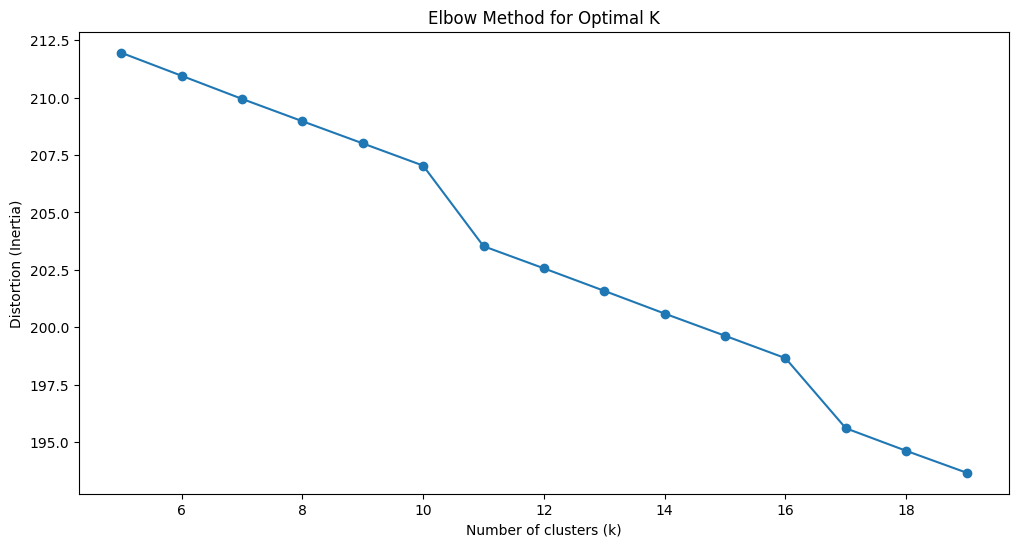

In [30]:
from sklearn.cluster import KMeans

texts = df["text"].tolist()

k_range = range(5, 20)
distortions = []

for n_clusters in k_range:
    X = vectorize_text(texts)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 6))

plt.plot(k_range, distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')



## Similar Items with K-Means

In [40]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import pytesseract

N_CLUSTERS = 11

# Function to find similar receipts using K-means clustering
def find_similar_receipts(new_receipt_text, receipt_texts, top_n=5, num_clusters=10):
    texts = receipt_texts + [new_receipt_text]
    X = vectorize_text(texts)
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    kmeans.fit(X)
    new_receipt_cluster = kmeans.predict(X[-1])
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == new_receipt_cluster]
    cluster_indices = [i for i in cluster_indices if i != len(receipt_texts)]
    similar_indices = cluster_indices[:top_n]
    similar_receipts = [texts[i] for i in similar_indices]

    return similar_indices, similar_receipts


new_receipt_text = df.iloc[0]["text"]
receipt_texts = df["text"].tolist()

similar_indices, similar_receipts = find_similar_receipts(new_receipt_text, receipt_texts)




## Similar Receipts with Cosine Similarities

In [26]:
import pytesseract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

image_path_, text = get_example_row(df.iloc[0])


def find_similar_receipts_with_cosine_sm(new_receipt_text, receipt_texts, top_n=5):
    # Preprocess the new receipt text
    processed_text = new_receipt_text
    texts = receipt_texts + [processed_text]
    # Convert all texts to TF-IDF vectors
    X = vectorize_text(texts)
    similarities = cosine_similarity(X[-1], X[:-1]).flatten()  # Similarity with all previous receipts
    # Sort by similarity and get the top N most similar receipts
    similar_indices = similarities.argsort()[-top_n:][::-1]
    return similar_indices, similarities[similar_indices]

new_receipt_text = df.iloc[0]["text"]
receipt_texts = df["text"].tolist()
similar_indices, similarities = find_similar_receipts_with_cosine_sm(new_receipt_text, receipt_texts)

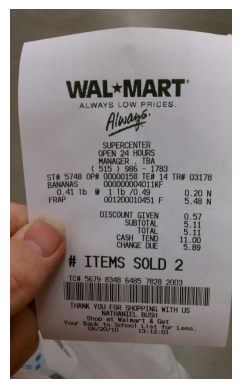

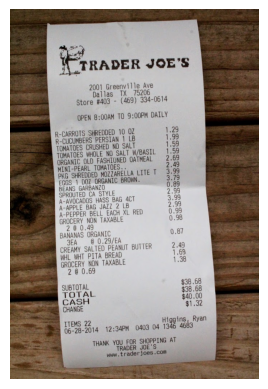

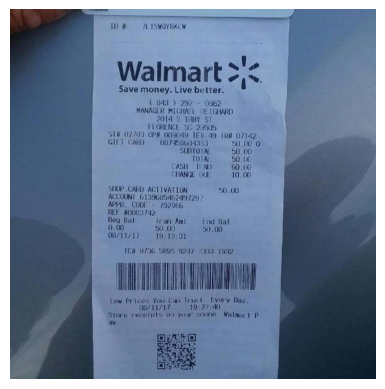

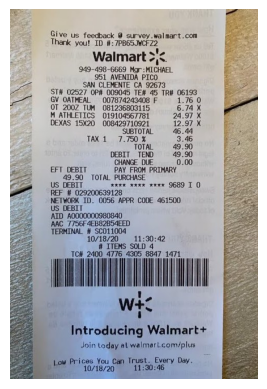

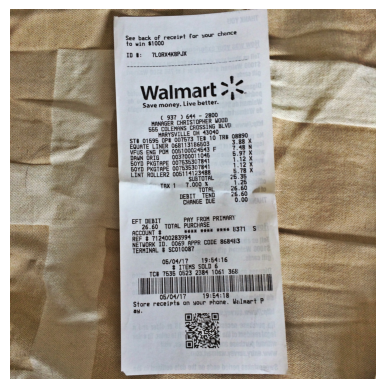

In [41]:
def get_and_show_similar_receipt(text=None, image_path=None, fn=find_similar_receipts):
  if text:
    similar_indices, similarities = fn(text, receipt_texts)
  else:
    text = extract_text_from_image(image_path)
    similar_indices, similarities = fn(text, receipt_texts)

  for idx, similarity in zip(similar_indices, similarities):
    image_path, _ = get_example_row(df.iloc[idx])
    img = plt.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

get_and_show_similar_receipt(image_path=image_path_, fn=find_similar_receipts)


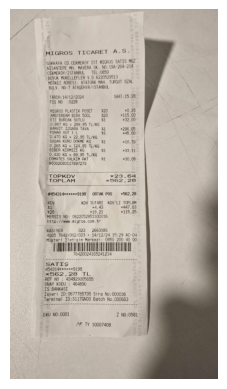

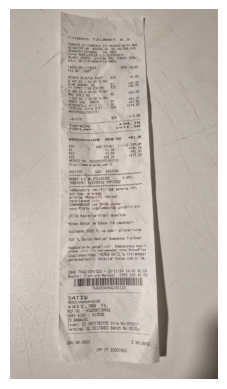

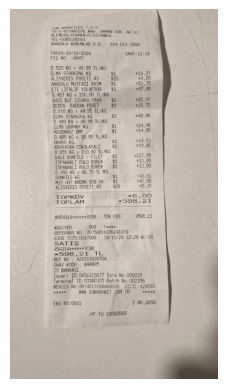

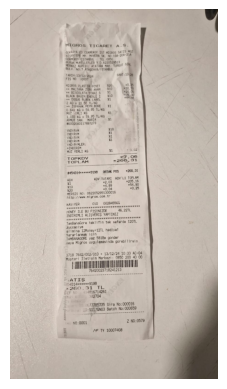

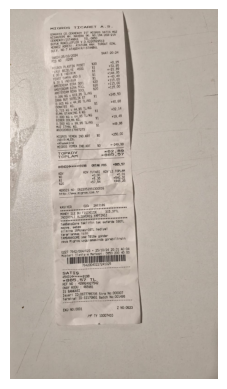

In [35]:
text = """MIGROS TIGARET A-S-

GOKKAYA CD. CEKMEKOY. TST MIGROS, SATIS. MGZ
MOMANTEPE. HH. MAVERA. SK. NO: 19A~20A-21A
CEKMEKOY/ISTANBUL TEL

BUYUK, MUMELLEFLER VD 6220829608

BUAEZ, ORES! : ATATORK MAK, TURGUT ZA.
Tey NO:7 ATASEHIR/STANBUL

rant: 28/10/2024 SAAT: 20:24
Fig NO 10295
*0,25
cps PLASTIK PoseT 420 0.
EAST BEZELYE 4506 a RS
490% NOTRIM tt £10495
FEAST BAMYA. 450 6 % sore)
¥115,00
¥115,00
+#115,00
#205 ,50
905 KG x 44,95 TL i
DONATES. HO og TUNG "1 40,68
0.715 KG x 44," iy
LAA STARING ANG “ 32,14
9 KG x 64,9
BIBER DOLNA KE “4 ¥19,49
500 KG x 99,95 TL/KG
wuz TTHAL KG “1 209,98
1¥6002080117897279
MIGROS YEMEK IND.KRT —*0 250,00
{NDIRIMLER:
xMYemekind
TOPKDV Ze2ke
TOPLAM ~585 57

Or a

yd5qaidxexxx29198 — ORTAK POS *885,57

KOV KOV TUTART KOV'LT TOPLAM
x0 0,00 0,01
x 35,35 540,31
20 57,54 345,25

NERSIS NO: 0622052951900016
http: //www.migros.com. tr

KASIYER 023 2663185

WONEY ILE BU FISINIZDE __919,977L
TNDIRINLI ALISVERIS YAPTINIZ

cee ece Tena RRRETERTERRENTEAEERETESS
TamBanacore teklifin tek seferde 160TL
meyve, sebze

elimina 16Money=16TL hediyel
Yararlannak icin

TAMBANAGORE yaz 5818e gonder

Veva Migros uygulanasinda gorebi Tirsin

227 7642/004/023 + 25/10/24 20:31 AC-04
Musteri Tletisim 00

ini

120040227241025

SATIS
G54314x*«H«x9198
*885,.57 TL
REF NO: 429924927542
ONAY KOOU : 465981

1S BANKAST
Yeyeri 10:0677785735 $ira No:000007
Terminal 1D:S117GNO1 Batch No:001498

EKO NO:0001
/F TY 10007410
"""

get_and_show_similar_receipt(text=text)

## Classification with Logistic Regression (RNN)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("./data/receipt_items.csv")

df = df.dropna(subset=['item_name', 'category'])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['item_name']).toarray()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
from torch.functional import F
class ItemClassifier(nn.Module):
    def __init__(self, in_features=3, h1=8, h2=9, out_features=9):
      super().__init__()
      self.fc1 = nn.Linear(in_features, h1)
      self.fc2 = nn.Linear(h1, h2)
      self.out = nn.Linear(h2, out_features)


    def forward(self, x):
        x =  F.relu(self.fc1(x))
        x =  F.relu(self.fc2(x))
        x = self.out(x)

        return x

torch.manual_seed(30) # for randomization. the argument could be anything


In [ ]:
# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
model = ItemClassifier(in_features=input_dim, out_features=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.0261
Epoch [2/50], Loss: 0.0258
Epoch [3/50], Loss: 0.0255
Epoch [4/50], Loss: 0.0253
Epoch [5/50], Loss: 0.0250
Epoch [6/50], Loss: 0.0247
Epoch [7/50], Loss: 0.0245
Epoch [8/50], Loss: 0.0242
Epoch [9/50], Loss: 0.0240
Epoch [10/50], Loss: 0.0238
Epoch [11/50], Loss: 0.0235
Epoch [12/50], Loss: 0.0233
Epoch [13/50], Loss: 0.0231
Epoch [14/50], Loss: 0.0229
Epoch [15/50], Loss: 0.0227
Epoch [16/50], Loss: 0.0225
Epoch [17/50], Loss: 0.0223
Epoch [18/50], Loss: 0.0221
Epoch [19/50], Loss: 0.0219
Epoch [20/50], Loss: 0.0218
Epoch [21/50], Loss: 0.0216
Epoch [22/50], Loss: 0.0214
Epoch [23/50], Loss: 0.0213
Epoch [24/50], Loss: 0.0211
Epoch [25/50], Loss: 0.0210
Epoch [26/50], Loss: 0.0208
Epoch [27/50], Loss: 0.0207
Epoch [28/50], Loss: 0.0205
Epoch [29/50], Loss: 0.0204
Epoch [30/50], Loss: 0.0203
Epoch [31/50], Loss: 0.0201
Epoch [32/50], Loss: 0.0200
Epoch [33/50], Loss: 0.0199
Epoch [34/50], Loss: 0.0197
Epoch [35/50], Loss: 0.0196
Epoch [36/50], Loss: 0.0195
E

In [ ]:

model.eval()  # evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(y_test_tensor, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4826
